In [1]:
from PyQt6.QtWidgets import QApplication, QMainWindow, QWidget, QLabel, QComboBox, QPushButton, QVBoxLayout, QHBoxLayout, QCheckBox, QSpacerItem, QSizePolicy
from PyQt6.QtGui import QIcon
from PyQt6.QtCore import Qt

import sys
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
import numpy as np

from monolayer_tracking.segmented_comprehension import Image, TimeSeries
from monolayer_tracking import preprocessing
import matplotlib

from tqdm import tqdm

# mpl canvas

In [14]:
class MplCanvas(FigureCanvasQTAgg):
    def __init__(self, parent=None, width=5, height=4, dpi=20):
        self.fig = Figure(figsize=(width, height), dpi=dpi)
        self.imgAx = self.fig.add_subplot(121)
        self.segAx = self.fig.add_subplot(122, sharex=self.imgAx, sharey=self.imgAx)

        for ax in [self.imgAx, self.segAx]:
            ax.set_aspect('equal')
        super(MplCanvas, self).__init__(self.fig)

In [5]:
class MainWidget(QMainWindow):
    def __init__(self):
        super().__init__()
        self.file_loaded=False
        self.setWindowTitle("Segmentation Reader")
        self.resize(720, 480)
        self.setAcceptDrops(True)
        self.is_panning = False

        # menu items
        self.menu_FUCCI_checkbox = QCheckBox("Show FUCCI Channel", self)
        self.menu_cc_overlay_dropdown = QComboBox(self)
        self.menu_cc_overlay_dropdown.addItems(["None", "Green", "Red", "All"])
        self.menu_overlay_label = QLabel("FUCCI overlay", self)
        self.spacer = QSpacerItem(20, 10, QSizePolicy.Policy.Expanding, QSizePolicy.Policy.Fixed)
        self.save_button=QPushButton("Save", self)

        self.menu_RGB_checkbox_widget=QWidget()
        self.menu_RGB_layout=QHBoxLayout(self.menu_RGB_checkbox_widget)
        self.menu_RGB_checkboxes=[QCheckBox(s, self) for s in ['R','G','B']]
        for checkbox in self.menu_RGB_checkboxes:
            checkbox.setChecked(True)
            self.menu_RGB_layout.addWidget(checkbox)


        # link menu items to methods
        self.menu_cc_overlay_dropdown.currentIndexChanged.connect(self.cc_overlay)
        self.menu_FUCCI_checkbox.stateChanged.connect(self.update_display)
        self.save_button.clicked.connect(self.save_segmentation)
        for checkbox in self.menu_RGB_checkboxes:
            checkbox.stateChanged.connect(self.update_display)
        
        # main layout
        main_widget = QWidget()
        self.setCentralWidget(main_widget)
        main_layout = QHBoxLayout(main_widget)
        self.toolbar=QWidget()
        self.toolbar_layout=QVBoxLayout(self.toolbar)
        self.canvas_widget=self.get_canvas()
        main_layout.addWidget(self.toolbar)
        main_layout.addWidget(self.canvas_widget)

        # menu widgets
        self.toolbar_layout.setSpacing(0)
        self.toolbar_layout.setAlignment(Qt.AlignmentFlag.AlignTop)
        self.toolbar.setFixedWidth(150)
        self.toolbar_layout.addWidget(self.menu_FUCCI_checkbox)
        self.toolbar_layout.addItem(self.spacer)
        self.toolbar_layout.addWidget(self.menu_overlay_label)
        self.toolbar_layout.addWidget(self.menu_cc_overlay_dropdown)
        self.toolbar_layout.addItem(self.spacer)
        self.toolbar_layout.addWidget(self.save_button)
        self.toolbar_layout.addWidget(self.menu_RGB_checkbox_widget)

    def save_segmentation(self):
        if not self.file_loaded:
            return
        green, red=np.array(self.frame.get_cell_attr(['green', 'red'])).T
        self.frame.cell_cycles=green+2*red
        self.frame.to_seg_npy('C:/Users/Andy/Desktop/test_export_seg.npy', write_attrs=['cell_cycles'])


    # drag and drop event
    def dragEnterEvent(self, event):
        if event.mimeData().hasUrls():
            event.accept()
        else:
            event.ignore()

    def dropEvent(self, event):
        files = [u.toLocalFile() for u in event.mimeData().urls()]
        self.load_files(files)
        self.frame_number=0
        if self.stack is not None:
            self.axlims=((0, self.stack.frames[0].img.shape[1]), (0, self.stack.frames[0].img.shape[0]))
            self.imshow(self.stack.frames[self.frame_number])

    # key press event
    def keyPressEvent(self, event):
        if not self.file_loaded:
            return
        if event.key() == 16777236: # right arrow
            if self.frame_number+1 < len(self.stack.frames):
                self.frame_number += 1
        elif event.key() == 16777234: # left arrow
            if self.frame_number > 0:
                self.frame_number -= 1
        else:
            return
        self.imshow(self.stack.frames[self.frame_number])
    
    # initialize canvas
    def get_canvas(self):
        self.canvas = MplCanvas(self, width=5, height=4, dpi=100)
        canvas_widget=QWidget()
        self.canvas_layout=QVBoxLayout(canvas_widget)
        self.canvas_layout.addWidget(self.canvas)

        #arrowkey_id = self.canvas.fig.canvas.mpl_connect('key_press_event', self.keyPressEvent)
        self.canvas.fig.canvas.mpl_connect('button_press_event', self.on_click_canvas)
        self.canvas.mpl_connect('motion_notify_event', self.on_mouse_move)
        self.canvas.mpl_connect('button_release_event', self.on_mouse_release)
        self.canvas.mpl_connect('scroll_event', self.zoom)
        return canvas_widget

    # zoom event
    def zoom(self, event):
        base_scale = 1.1  # Zoom factor

        # Determine the direction of the scroll (up or down)
        if event.button == 'up':
            scale_factor = 1 / base_scale
        elif event.button == 'down':
            scale_factor = base_scale
        else:
            return  # Ignore other events

        # Get the current x and y limits
        x_left, x_right = self.canvas.imgAx.get_xlim()
        y_bottom, y_top = self.canvas.imgAx.get_ylim()

        # Get the mouse position in data coordinates
        xdata, ydata = event.xdata, event.ydata

        # If the scroll is within the plot
        if xdata is None or ydata is None:
            return

        # Apply zooming by scaling the x and y limits relative to the mouse position
        new_x_left = xdata - (xdata - x_left) * scale_factor
        new_x_right = xdata + (x_right - xdata) * scale_factor
        new_y_bottom = ydata - (ydata - y_bottom) * scale_factor
        new_y_top = ydata + (y_top - ydata) * scale_factor

        # Update the x and y limits
        self.axlims = ((new_x_left, new_x_right), (new_y_bottom, new_y_top))

        # Efficiently update the canvas without full redraw
        self.redraw_axlims()

    def select_cell(self, current_cell):
        if current_cell.n>=0: # is a cell, not background
            if current_cell.n==self.current_cell_n: # clicked on the same cell
                print(f'Deselected cell {current_cell.n}')
                self.clear_highlight(current_cell.n)
                self.current_cell_n=None
            else:
                print(f'Selected cell {current_cell.n}')
                if self.current_cell_n is not None:
                    self.clear_highlight(self.current_cell_n)
                self.highlight_cells(current_cell)
                self.current_cell_n=current_cell.n
    # mouse events
    def on_click_canvas(self, event):
        if not self.file_loaded:
            return
        if event.button==1: # left click: highlight cell
            # retrieve the clicked cell
            current_cell_n, _, _=self.get_cell(event)
            current_cell=self.frame.cells[current_cell_n]

            # highlight the cell
            selected_cc=self.menu_cc_overlay_dropdown.currentText().lower()
            if selected_cc=="none": # default mode, just highlight
                self.select_cell(current_cell)
            else: # cell cycle overlay mode
                if current_cell_n>=0: # is a cell, not background
                    setattr(current_cell, selected_cc, not getattr(current_cell, selected_cc))
                    self.draw_cc_overlay(selected_cc)
            return current_cell_n
    
        elif event.button == 3:  # Right-click to start panning
            self.is_panning = True
            self.last_mouse_position = (event.xdata, event.ydata)
            self.img_background = self.canvas.copy_from_bbox(self.canvas.imgAx.bbox)
            self.seg_background = self.canvas.copy_from_bbox(self.canvas.segAx.bbox)

    def on_mouse_move(self, event):
        if self.is_panning and event.xdata is not None and event.ydata is not None:
            dx = event.xdata - self.last_mouse_position[0]
            dy = event.ydata - self.last_mouse_position[1]

            # Get the current limits
            x_left, x_right = self.canvas.imgAx.get_xlim()
            y_bottom, y_top = self.canvas.imgAx.get_ylim()

            # Calculate new limits based on mouse movement

            self.axlims=((x_left-dx, x_right-dx), (y_bottom-dy, y_top-dy))

            # Update the last mouse position
            self.last_mouse_position = (event.xdata, event.ydata)

            # Efficiently update the canvas without full redraw
            self.redraw_axlims()

    def on_mouse_release(self, event):
        if event.button == 3:
            self.is_panning = False
            self.last_mouse_position = None
    
    def redraw_axlims(self):
        xlims, ylims = self.axlims
        for ax in [self.canvas.imgAx, self.canvas.segAx]:
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
        
        # Restore background and blit the updated part
        self.canvas.restore_region(self.img_background)
        self.canvas.restore_region(self.seg_background)
        self.canvas.blit(self.canvas.imgAx.bbox)
        self.canvas.blit(self.canvas.segAx.bbox)
        self.canvas.draw_idle()

    # cell highlighting
    def highlight_cells(self, cells, color='white', ec=None, alpha=0.3):
        if not isinstance(cells, (list, tuple, np.ndarray)): # single cell
            cells=[cells]
        for cell in cells:
            cell.highlighted.extend([ax.fill(*cell.outline.T, color=color, ec=ec, alpha=alpha)[0] for ax in [self.canvas.imgAx, self.canvas.segAx]])
        
        self.canvas.draw()
    
    def clear_highlight(self, cells=slice(None)):
        if isinstance(cells, (int, np.integer)):
            cells=[cells]
        for cell in self.frame.cells[cells]:
            if hasattr(cell, 'highlighted'):
                for polygon in cell.highlighted:
                    polygon.remove()
            cell.highlighted=[]
        self.canvas.draw_idle()
    
    def get_cell(self, event):
        if hasattr(self, 'stack'):
            ix, iy = event.xdata, event.ydata
            if not ix or not iy:
                return -1, ix, iy
            else:
                cell_n=self.frame.masks[int(iy),int(ix)]-1
                return cell_n, ix, iy
    
    # cell cycle highlighting
    def cc_overlay(self):
        self.clear_highlight()
        if self.menu_cc_overlay_dropdown.currentText()=="None":
            return
        else:
            self.drawn_cells_n={"green":set(), "red":set()}
            for cell in self.frame.cells:
                self.canvas.imgAx.plot(cell.outline[:,0], cell.outline[:,1], 'white', alpha=0.4, lw=1)
            self.draw_cc_overlay()

    def draw_cc_overlay(self, selected_color=None):
        if not selected_color:
            selected_color=self.menu_cc_overlay_dropdown.currentText().lower()
        
        if selected_color=="all":
            self.draw_cc_overlay("green")
            self.draw_cc_overlay("red")
        else:
            all_colored=set(np.where(self.frame.get_cell_attr(selected_color))[0])
            to_erase=self.drawn_cells_n[selected_color]-all_colored # find cells that are no longer selected
            self.clear_highlight(list(to_erase)) # erase cells that are no longer selected

            to_draw_n=all_colored-self.drawn_cells_n[selected_color] # only draw cells that are not already drawn

            self.highlight_cells(self.frame.cells[list(to_draw_n)], color=selected_color[0], ec='none', alpha=0.3)
            self.drawn_cells_n[selected_color]=all_colored

    # draw image data
    def imshow(self, frame):
        self.frame=frame
        self.canvas.imgAx.clear()
        self.canvas.segAx.clear()
        self.clear_highlight()
        self.current_cell_n=None
        self.get_red_green()
        if self.menu_FUCCI_checkbox.isChecked():
            img_data=np.stack([self.frame.FUCCI[0], self.frame.FUCCI[1], np.zeros_like(self.frame.FUCCI[0])], axis=-1)
        else:
            # Otherwise, show frame.img
            img_data=preprocessing.normalize(self.frame.img, quantile=(0.01,0.99))
        
        RGB_checks=[checkbox.isChecked() for checkbox in self.menu_RGB_checkboxes]
        for i, check in enumerate(RGB_checks):
            if not check:
                img_data[...,i]=0

        self.canvas.draw()
        self.canvas.imgAx.imshow(img_data, cmap='gray')
        self.canvas.segAx.imshow(self.frame.outlines.todense()!=0, cmap='gray')

        self.img_background = self.canvas.copy_from_bbox(self.canvas.imgAx.bbox)
        self.seg_background = self.canvas.copy_from_bbox(self.canvas.segAx.bbox)
        self.canvas.imgAx.set_title(f'Image - frame {self.frame_number+1}')
        self.canvas.segAx.set_title(f'Segmentation - frame {self.frame_number+1}')

        self.redraw_axlims()
        self.canvas.draw()
        

    def update_display(self):
        """Update the display when the checkbox state changes."""
        if self.file_loaded:
            self.imshow(self.frame)  # Redraw based on the checkbox state

            if self.menu_cc_overlay_dropdown.currentText()!="None":
                self.cc_overlay()
    
    def get_red_green(self):
        for cell in self.frame.cells:
            if hasattr(cell, 'cycle_stage'):
                cell.green=cell.cycle_stage==1 or cell.cycle_stage==3
                cell.red=cell.cycle_stage==2 or cell.cycle_stage==3
            else:
                cell.red=False
                cell.green=False

    # load seg.npy files
    def load_files(self, files):
        if files[0].endswith('seg.npy'): # single segmented file
            self.stack=TimeSeries(frame_paths=files, load_img=True)
            print(f'Loaded segmentation file {files[0]}')
            self.file_loaded=True
        else:
            try: # maybe it's a folder of segmented files?
                self.stack=TimeSeries(stack_path=files[0], verbose_load=True, progress_bar=tqdm, load_img=True)
                print(f'Loaded stack {files[0]}')
            except FileNotFoundError: # nope, just reject it
                print(f'ERROR: File {files[0]} is not a seg.npy file, cannot be loaded.')


In [18]:
get_rgb('green')

(0.0, 0.5019607843137255, 0.0)

# vispy

In [22]:
from vispy.scene import PanZoomCamera
from vispy import scene

class VispyCanvas(scene.SceneCanvas):
    def __init__(self, width=800, height=600):
        # Initialize the SceneCanvas
        super().__init__(keys='interactive', size=(width, height), show=True)

        # Unfreeze the canvas so that attributes can be added
        self.unfreeze()

        # Create a grid layout for two views (image and segmentation)
        grid = self.central_widget.add_grid(spacing=10)

        # Create two viewboxes for image and segmentation
        self.img_view = grid.add_view(row=0, col=0, border_color='white')
        self.img_view.camera = PanZoomCamera(aspect=1)
        self.img_view.camera.interactive = True

        self.seg_view = grid.add_view(row=0, col=1, border_color='white')
        self.seg_view.camera = self.img_view.camera  # Link the cameras for synchronized pan/zoom

        # Add visuals for image and segmentation
        self.img_data = np.random.randint(0,256,(500, 500))
        self.seg_data = (np.random.random((500, 500)) > 128).astype(np.int8)

        self.img_visual = scene.visuals.Image(self.img_data, parent=self.img_view.scene, cmap='gray')
        self.seg_visual = scene.visuals.Image(self.seg_data, parent=self.seg_view.scene, cmap='gray')

        # Freeze the canvas again after adding the attributes
        self.freeze()

    def update_image(self, new_img_data, new_seg_data):
        """Update the displayed image and segmentation."""
        self.img_visual.set_data(new_img_data)
        self.seg_visual.set_data(new_seg_data)
        self.img_view.camera.set_range()
        self.seg_view.camera.set_range()

    def zoom(self, scale_factor):
        """Zoom functionality."""
        for view in [self.img_view, self.seg_view]:
            view.camera.zoom(scale_factor)

    def pan(self, dx, dy):
        """Pan functionality."""
        for view in [self.img_view, self.seg_view]:
            view.camera.pan((dx, dy))


In [26]:
from PyQt6.QtWidgets import QMainWindow, QVBoxLayout, QWidget, QHBoxLayout, QCheckBox, QComboBox, QLabel, QPushButton, QSpacerItem, QSizePolicy
from PyQt6.QtCore import Qt
import numpy as np
from vispy.visuals.transforms import STTransform
import sys


class MainWidget(QMainWindow):
    def __init__(self):
        super().__init__()
        self.file_loaded = False
        self.setWindowTitle("VisPy Segmentation Viewer")
        self.resize(720, 480)
        self.is_panning = False

        # Menu items (using PyQt)
        self.menu_FUCCI_checkbox = QCheckBox("Show FUCCI Channel", self)
        self.menu_cc_overlay_dropdown = QComboBox(self)
        self.menu_cc_overlay_dropdown.addItems(["None", "Green", "Red", "All"])
        self.menu_overlay_label = QLabel("FUCCI overlay", self)
        self.spacer = QSpacerItem(20, 10, QSizePolicy.Policy.Expanding, QSizePolicy.Policy.Fixed)
        self.save_button = QPushButton("Save", self)

        self.menu_RGB_checkbox_widget = QWidget()
        self.menu_RGB_layout = QHBoxLayout(self.menu_RGB_checkbox_widget)
        self.menu_RGB_checkboxes = [QCheckBox(s, self) for s in ['R', 'G', 'B']]
        for checkbox in self.menu_RGB_checkboxes:
            checkbox.setChecked(True)
            self.menu_RGB_layout.addWidget(checkbox)

        # Link menu items to methods
        self.menu_cc_overlay_dropdown.currentIndexChanged.connect(self.cc_overlay)
        self.menu_FUCCI_checkbox.stateChanged.connect(self.update_display)
        self.save_button.clicked.connect(self.save_segmentation)
        for checkbox in self.menu_RGB_checkboxes:
            checkbox.stateChanged.connect(self.update_display)

        # Main layout
        main_widget = QWidget()
        self.setCentralWidget(main_widget)
        main_layout = QHBoxLayout(main_widget)
        self.toolbar = QWidget()
        self.toolbar_layout = QVBoxLayout(self.toolbar)
        self.canvas_widget = self.get_canvas()
        main_layout.addWidget(self.toolbar)
        main_layout.addWidget(self.canvas_widget)

        # Toolbar widgets
        self.toolbar_layout.setSpacing(0)
        self.toolbar_layout.setAlignment(Qt.AlignmentFlag.AlignTop)
        self.toolbar.setFixedWidth(150)
        self.toolbar_layout.addWidget(self.menu_FUCCI_checkbox)
        self.toolbar_layout.addItem(self.spacer)
        self.toolbar_layout.addWidget(self.menu_overlay_label)
        self.toolbar_layout.addWidget(self.menu_cc_overlay_dropdown)
        self.toolbar_layout.addItem(self.spacer)
        self.toolbar_layout.addWidget(self.save_button)
        self.toolbar_layout.addWidget(self.menu_RGB_checkbox_widget)

        self.file_loaded = False

    def save_segmentation(self):
        if not self.file_loaded:
            return
        # This is a placeholder for saving the segmentation data
        print("Segmentation saved.")

    def get_canvas(self):
        """Initialize the VisPy canvas."""
        self.canvas = VispyCanvas()
        canvas_widget = QWidget()
        self.canvas_layout = QVBoxLayout(canvas_widget)
        self.canvas_layout.addWidget(self.canvas.native)
        return canvas_widget

    def update_display(self):
        """Update the display when checkboxes change."""
        if self.file_loaded:
            # Placeholder: Update the visuals on checkbox change
            print("Display updated.")

    def cc_overlay(self):
        """Handle cell cycle overlay options."""
        # Placeholder: Handle changes in the dropdown for overlays
        print("Cell cycle overlay changed.")

    # Drag and drop event
    def dragEnterEvent(self, event):
        if event.mimeData().hasUrls():
            event.accept()
        else:
            event.ignore()

    def dropEvent(self, event):
        files = [u.toLocalFile() for u in event.mimeData().urls()]
        self.load_files(files)
        self.frame_number = 0
        if self.stack is not None:
            self.update_display()

    def keyPressEvent(self, event):
        """Handle key press events (e.g., arrow keys for frame navigation)."""
        if not self.file_loaded:
            return
        # Placeholder: Handle frame navigation

    def load_files(self, files):
        """Load segmentation files."""
        if files[0].endswith('seg.npy'): # single segmented file
            self.stack=TimeSeries(frame_paths=files, load_img=True)
            print(f'Loaded segmentation file {files[0]}')
            self.file_loaded=True
        else:
            try: # maybe it's a folder of segmented files?
                self.stack=TimeSeries(stack_path=files[0], verbose_load=True, progress_bar=tqdm, load_img=True)
                print(f'Loaded stack {files[0]}')
            except FileNotFoundError: # nope, just reject it
                print(f'ERROR: File {files[0]} is not a seg.npy file, cannot be loaded.')

    def zoom(self, event):
        """Zoom event handler for mouse scroll."""
        self.canvas.zoom(event)

    def pan(self, event):
        """Pan the view when right-click dragging."""
        if event.is_panning:
            dx = event.dx
            dy = event.dy
            self.canvas.pan(dx, dy)

# pyqtgraph

In [1]:
import sys
import numpy as np
from PyQt6.QtWidgets import (
    QApplication, QMainWindow, QWidget, QLabel, QComboBox, QPushButton,
    QVBoxLayout, QHBoxLayout, QCheckBox, QSpacerItem, QSizePolicy
)
from PyQt6.QtCore import Qt
import pyqtgraph as pg

from monolayer_tracking.segmented_comprehension import Image, TimeSeries
from monolayer_tracking import preprocessing

class PyQtGraphCanvas(QWidget):
    def __init__(self, parent=None, width=800, height=600):
        super().__init__(parent)
        self.parent = parent
        
        # Create a layout for the widget
        self.layout = QHBoxLayout()
        self.setLayout(self.layout)

        # Create a PlotWidget for the image and segmentation views
        self.img_plot = pg.PlotWidget(title="Image", border="w")
        self.seg_plot = pg.PlotWidget(title="Segmentation", border="w")
        
        # Add the plots to the layout
        self.layout.addWidget(self.img_plot)
        self.layout.addWidget(self.seg_plot)

        # Initialize data
        self.img_data = np.random.randint(0, 256, (500, 500))
        self.seg_data = (np.random.random((500, 500)) > 0.5)

        # Plot the data
        self.img_item = pg.ImageItem(self.img_data)
        self.seg_item = pg.ImageItem(self.seg_data)

        self.img_plot.addItem(self.img_item)
        self.seg_plot.addItem(self.seg_item)

        self.img_plot.setAspectLocked(True)
        self.seg_plot.setAspectLocked(True)

        # Set initial zoom levels
        self.img_plot.setRange(xRange=[0, self.img_data.shape[1]], yRange=[0, self.img_data.shape[0]], padding=0)
        self.seg_plot.setRange(xRange=[0, self.seg_data.shape[1]], yRange=[0, self.seg_data.shape[0]], padding=0)

        # Connect the range change signals to the custom slots
        self.img_plot.sigRangeChanged.connect(self.sync_seg_plot)
        self.seg_plot.sigRangeChanged.connect(self.sync_img_plot)

        # Connect the mouse move signals to the custom slots
        self.img_plot.scene().sigMouseMoved.connect(self.update_cursor)
        self.seg_plot.scene().sigMouseMoved.connect(self.update_cursor)

        # Create crosshair lines
        self.img_vline = pg.InfiniteLine(angle=90, movable=False)
        self.img_hline = pg.InfiniteLine(angle=0, movable=False)
        self.seg_vline = pg.InfiniteLine(angle=90, movable=False)
        self.seg_hline = pg.InfiniteLine(angle=0, movable=False)

        self.img_plot.addItem(self.img_vline, ignoreBounds=True)
        self.img_plot.addItem(self.img_hline, ignoreBounds=True)
        self.seg_plot.addItem(self.seg_vline, ignoreBounds=True)
        self.seg_plot.addItem(self.seg_hline, ignoreBounds=True)

    def get_pixel_coords(self, pos):
        """Get the pixel coordinates of the mouse cursor."""
        mouse_point = self.img_plot.plotItem.vb.mapSceneToView(pos)
        x, y = int(mouse_point.x()), int(mouse_point.y())
        return x, y
    
    def update_cursor(self, pos):
        """Update the segmentation plot cursor based on the image plot cursor."""
        if self.img_plot.sceneBoundingRect().contains(pos):
            mouse_point = self.img_plot.plotItem.vb.mapSceneToView(pos)
        elif self.seg_plot.sceneBoundingRect().contains(pos):
            mouse_point = self.seg_plot.plotItem.vb.mapSceneToView(pos)
        self.seg_vline.setPos(mouse_point.x())
        self.seg_hline.setPos(mouse_point.y())
        self.img_vline.setPos(mouse_point.x())
        self.img_hline.setPos(mouse_point.y())

    def update_display(self, img_data=None, seg_data=None):
        """Update the display when checkboxes change."""
        if img_data is not None:
            self.img_data = img_data
        if seg_data is not None:
            self.seg_data = seg_data

        # RGB checkboxes
        RGB_checks = [checkbox.isChecked() for checkbox in self.parent.menu_RGB_checkboxes]
        for i, check in enumerate(RGB_checks):
            if not check:
                self.img_data[..., i] = 0
            
        # Grayscale checkbox
        if self.parent.menu_grayscale.isChecked():
            self.img_data = np.mean(self.img_data, axis=-1)
        self.img_item.setImage(self.img_data)
        self.seg_item.setImage(self.seg_data)

    def sync_img_plot(self, view_box):
        """Sync the image plot view range with the segmentation plot."""
        self.img_plot.blockSignals(True)
        self.img_plot.setRange(xRange=self.seg_plot.viewRange()[0], yRange=self.seg_plot.viewRange()[1], padding=0)
        self.img_plot.blockSignals(False)

    def sync_seg_plot(self, view_box):
        """Sync the segmentation plot view range with the image plot."""
        self.seg_plot.blockSignals(True)
        self.seg_plot.setRange(xRange=self.img_plot.viewRange()[0], yRange=self.img_plot.viewRange()[1], padding=0)
        self.seg_plot.blockSignals(False)

class MainWidget(QMainWindow):
    def __init__(self):
        super().__init__()
        self.file_loaded = False
        self.setWindowTitle("PyQtGraph Segmentation Viewer")
        self.resize(720, 480)

        # Menu items (using PyQt)
        self.menu_FUCCI_checkbox = QCheckBox("Show FUCCI Channel", self)
        self.menu_cc_overlay_dropdown = QComboBox(self)
        self.menu_cc_overlay_dropdown.addItems(["None", "Green", "Red", "All"])
        self.menu_overlay_label = QLabel("FUCCI overlay", self)
        self.spacer = QSpacerItem(20, 10, QSizePolicy.Policy.Expanding, QSizePolicy.Policy.Fixed)
        self.save_button = QPushButton("Save", self)

        self.menu_RGB_checkbox_widget = QWidget()
        self.menu_RGB_layout = QHBoxLayout(self.menu_RGB_checkbox_widget)
        self.menu_RGB_checkboxes = [QCheckBox(s, self) for s in ['R', 'G', 'B']]
        for checkbox in self.menu_RGB_checkboxes:
            checkbox.setChecked(True)
            self.menu_RGB_layout.addWidget(checkbox)
        self.menu_grayscale=QCheckBox("Grayscale", self)

        # Main layout
        main_widget = QWidget()
        self.setCentralWidget(main_widget)
        main_layout = QHBoxLayout(main_widget)
        self.toolbar = QWidget()
        self.toolbar_layout = QVBoxLayout(self.toolbar)
        self.canvas_widget = self.get_canvas()
        main_layout.addWidget(self.toolbar)
        main_layout.addWidget(self.canvas_widget)

        # Toolbar widgets
        self.toolbar_layout.setSpacing(0)
        self.toolbar_layout.setAlignment(Qt.AlignmentFlag.AlignTop)
        self.toolbar.setFixedWidth(150)
        self.toolbar_layout.addWidget(self.menu_FUCCI_checkbox)
        self.toolbar_layout.addItem(self.spacer)
        self.toolbar_layout.addWidget(self.menu_overlay_label)
        self.toolbar_layout.addWidget(self.menu_cc_overlay_dropdown)
        self.toolbar_layout.addItem(self.spacer)
        self.toolbar_layout.addWidget(self.save_button)
        self.toolbar_layout.addWidget(self.menu_RGB_checkbox_widget)
        self.toolbar_layout.addWidget(self.menu_grayscale)

        self.file_loaded = False
        
        # Link menu items to methods
        self.menu_cc_overlay_dropdown.currentIndexChanged.connect(self.cc_overlay)
        self.menu_FUCCI_checkbox.stateChanged.connect(self.update_display)
        self.save_button.clicked.connect(self.save_segmentation)
        for checkbox in self.menu_RGB_checkboxes:
            checkbox.stateChanged.connect(self.update_display)
        self.menu_grayscale.stateChanged.connect(self.update_display)

        # click event
        self.canvas.img_plot.scene().sigMouseClicked.connect(self.on_click)
        self.canvas.seg_plot.scene().sigMouseClicked.connect(self.on_click)
    
    def update_display(self):
        """Update the display when checkboxes change."""
        if self.file_loaded:
            img_data=preprocessing.normalize(self.frame.img, quantile=(0.01,0.99))
            self.canvas.update_display(img_data=img_data, seg_data=self.frame.outlines.todense()!=0)
        
    def on_click(self, event):
        if event.button() == Qt.MouseButton.LeftButton:
            x, y = self.canvas.get_pixel_coords(event.scenePos())
            if self.file_loaded:
                current_cell_n = self.get_cell(x, y)
                if current_cell_n is None:
                    self.selected_cell=None
                    print(f"Clicked on background at position ({x}, {y})")
                elif current_cell_n>=0:
                    if current_cell_n==self.selected_cell:
                        self.current_cell_n=None
                        print(f'Deselected cell {current_cell_n} at position ({x}, {y})')
                    else:
                        self.selected_cell=current_cell_n
                    print(f"Clicked on cell {self.selected_cell} at position ({x}, {y})")
                else:
                    raise ValueError(f"Invalid cell number {current_cell_n} at position ({x}, {y})")
    
    def get_cell(self, x, y):
        if x < 0 or y < 0 or x >= self.canvas.img_data.shape[1] or y >= self.canvas.img_data.shape[0]:
            return -1 # out of bounds
        cell_n=self.frame.masks[x, y]-1
        return cell_n
        
    def save_segmentation(self):
        if not self.file_loaded:
            return
        # This is a placeholder for saving the segmentation data
        print("Segmentation saved.")

    def get_canvas(self):
        """Initialize the PyQtGraph canvas."""
        self.canvas = PyQtGraphCanvas(parent=self)
        canvas_widget = QWidget()
        self.canvas_layout = QVBoxLayout(canvas_widget)
        self.canvas_layout.addWidget(self.canvas)
        
        return canvas_widget

    def cc_overlay(self):
        """Handle cell cycle overlay options."""
        # Placeholder: Handle changes in the dropdown for overlays
        print("Cell cycle overlay changed.")

    # Drag and drop event
    def dragEnterEvent(self, event):
        if event.mimeData().hasUrls():
            event.accept()
        else:
            event.ignore()

    def imshow(self, frame):
        ''' Display the image and segmentation data for a given frame. Should be run once per loading a new frame.'''
        self.frame = frame
        self.selected_cell=None
        self.canvas.update_display(preprocessing.normalize(frame.img), frame.outlines.todense()!=0)
    
    def update_RGB(self):
        """Update the display when the FUCCI checkbox changes."""
        self.canvas.RGB=[checkbox.isChecked() for checkbox in self.menu_RGB_checkboxes]
        self.canvas.update_display()

    def dropEvent(self, event):
        files = [u.toLocalFile() for u in event.mimeData().urls()]
        self.load_files(files)
        self.frame_number = 0
        if self.stack is not None:
            self.imshow(self.stack.frames[self.frame_number])

    def keyPressEvent(self, event):
        """Handle key press events (e.g., arrow keys for frame navigation)."""
        if not self.file_loaded:
            return
        # Placeholder: Handle frame navigation

    def load_files(self, files):
        """Load segmentation files."""
        self.file_loaded = True
        if files[0].endswith('seg.npy'): # single segmented file
            self.stack=TimeSeries(frame_paths=files, load_img=True)
            print(f'Loaded segmentation file {files[0]}')
        else:
            try: # maybe it's a folder of segmented files?
                self.stack=TimeSeries(stack_path=files[0], verbose_load=True, progress_bar=tqdm, load_img=True)
                print(f'Loaded stack {files[0]}')
            except FileNotFoundError: # nope, just reject it
                print(f'ERROR: File {files[0]} is not a seg.npy file, cannot be loaded.')
                self.file_loaded = False

In [6]:
# get RGB code for matplotlib color string
import matplotlib
def get_rgb(color):
    return matplotlib.colors.to_rgb(color)

get_rgb('orange')

(1.0, 0.6470588235294118, 0.0)

In [10]:
get_rgb((1,1,1))

(1.0, 1.0, 1.0)

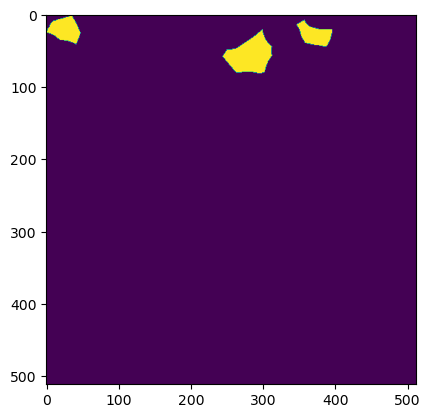

In [9]:
test_img=Image('C:/Users/Andy/Desktop/test_export_seg.npy')
import matplotlib.pyplot as plt

plt.imshow(np.isin(test_img.masks, [1,5,10]))

In [17]:
test_img.masks[...,np.newaxis]*(list(get_rgb('r'))+[1])

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

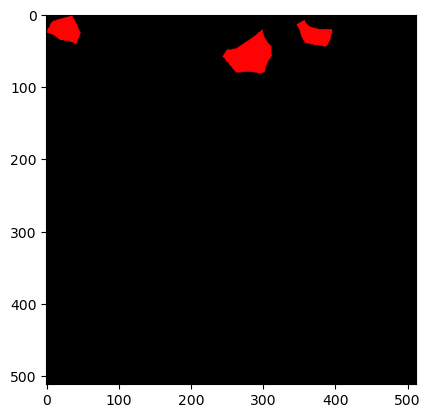

In [14]:
plt.imshow(np.isin(test_img.masks, [1,5,10])[...,np.newaxis]*[255,2,3])

In [2]:
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance()
app.quitOnLastWindowClosed = True
ui = MainWidget()
ui.show()
app.exec()

Loaded segmentation file C:/Users/Andy/Desktop/Heather_temp/segmented/500k/p1_500k-0_seg.npy


ValueError: Invalid cell number -1 at position (283, 484)

Clicked on cell None at position (27, 417)
Clicked on cell None at position (95, 352)
Clicked on cell None at position (151, 284)


0

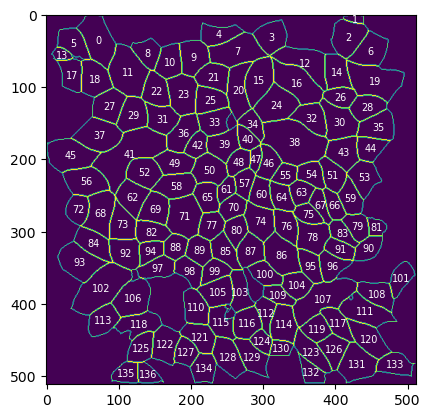

In [9]:
import matplotlib.pyplot as plt
test_img=Image(r'C:\Users\Andy\Desktop\Heather_temp\segmented\500k\p1_500k-0_seg.npy')
plt.imshow(test_img.outlines.todense()!=0)
test_img.get_centroids()
for cell in test_img.cells:
    # label centroids with cell number
    plt.text(cell.centroid[1], cell.centroid[0], str(cell.n), fontsize=7, color='white', va='center', ha='center')

# run

In [27]:
if __name__ == '__main__':
    if not QApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QApplication.instance()
    app.quitOnLastWindowClosed = True
    ui = MainWidget()
    ui.show()
    sys.exit(app.exec())

RFBOutputContext()

TypeError: addWidget(self, a0: Optional[QWidget], stretch: int = 0, alignment: Qt.AlignmentFlag = Qt.Alignment()): argument 1 has unexpected type 'CanvasBackend'

In [32]:
a=VispyCanvas()

RFBOutputContext()

In [36]:
type(a.native)

vispy.app.backends._jupyter_rfb.CanvasBackend

In [5]:
test_img=Image(r"C:\Users\Andy\Desktop\test_export_seg.npy")

In [6]:
# check if a is an int or an iterable
test_img.cell_cycles

array([1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 3, 3, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 3, 3, 0, 3, 0, 0, 0, 3, 0, 1, 1, 3,
       0, 1, 1, 1, 3, 1, 0, 1, 3, 2, 3, 3, 3, 1, 2, 3, 1, 2, 3, 1, 1, 2,
       1, 1, 2, 1, 2, 3, 2, 2, 2, 2, 3, 2, 0, 2, 3, 1, 2, 1, 1, 0, 2, 1,
       1, 1, 1, 3, 3, 1, 2, 2, 0, 1, 0, 3, 0, 1, 1, 1, 2, 2, 1, 3, 3, 1,
       3, 1, 1, 3, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1])

In [121]:
cells=np.linspace(10,0)



True

In [122]:
test_img.cells[[0]]

array([<monolayer_tracking.segmented_comprehension.Cell object at 0x0000025D16BC3AD0>],
      dtype=object)